FRAP data plot

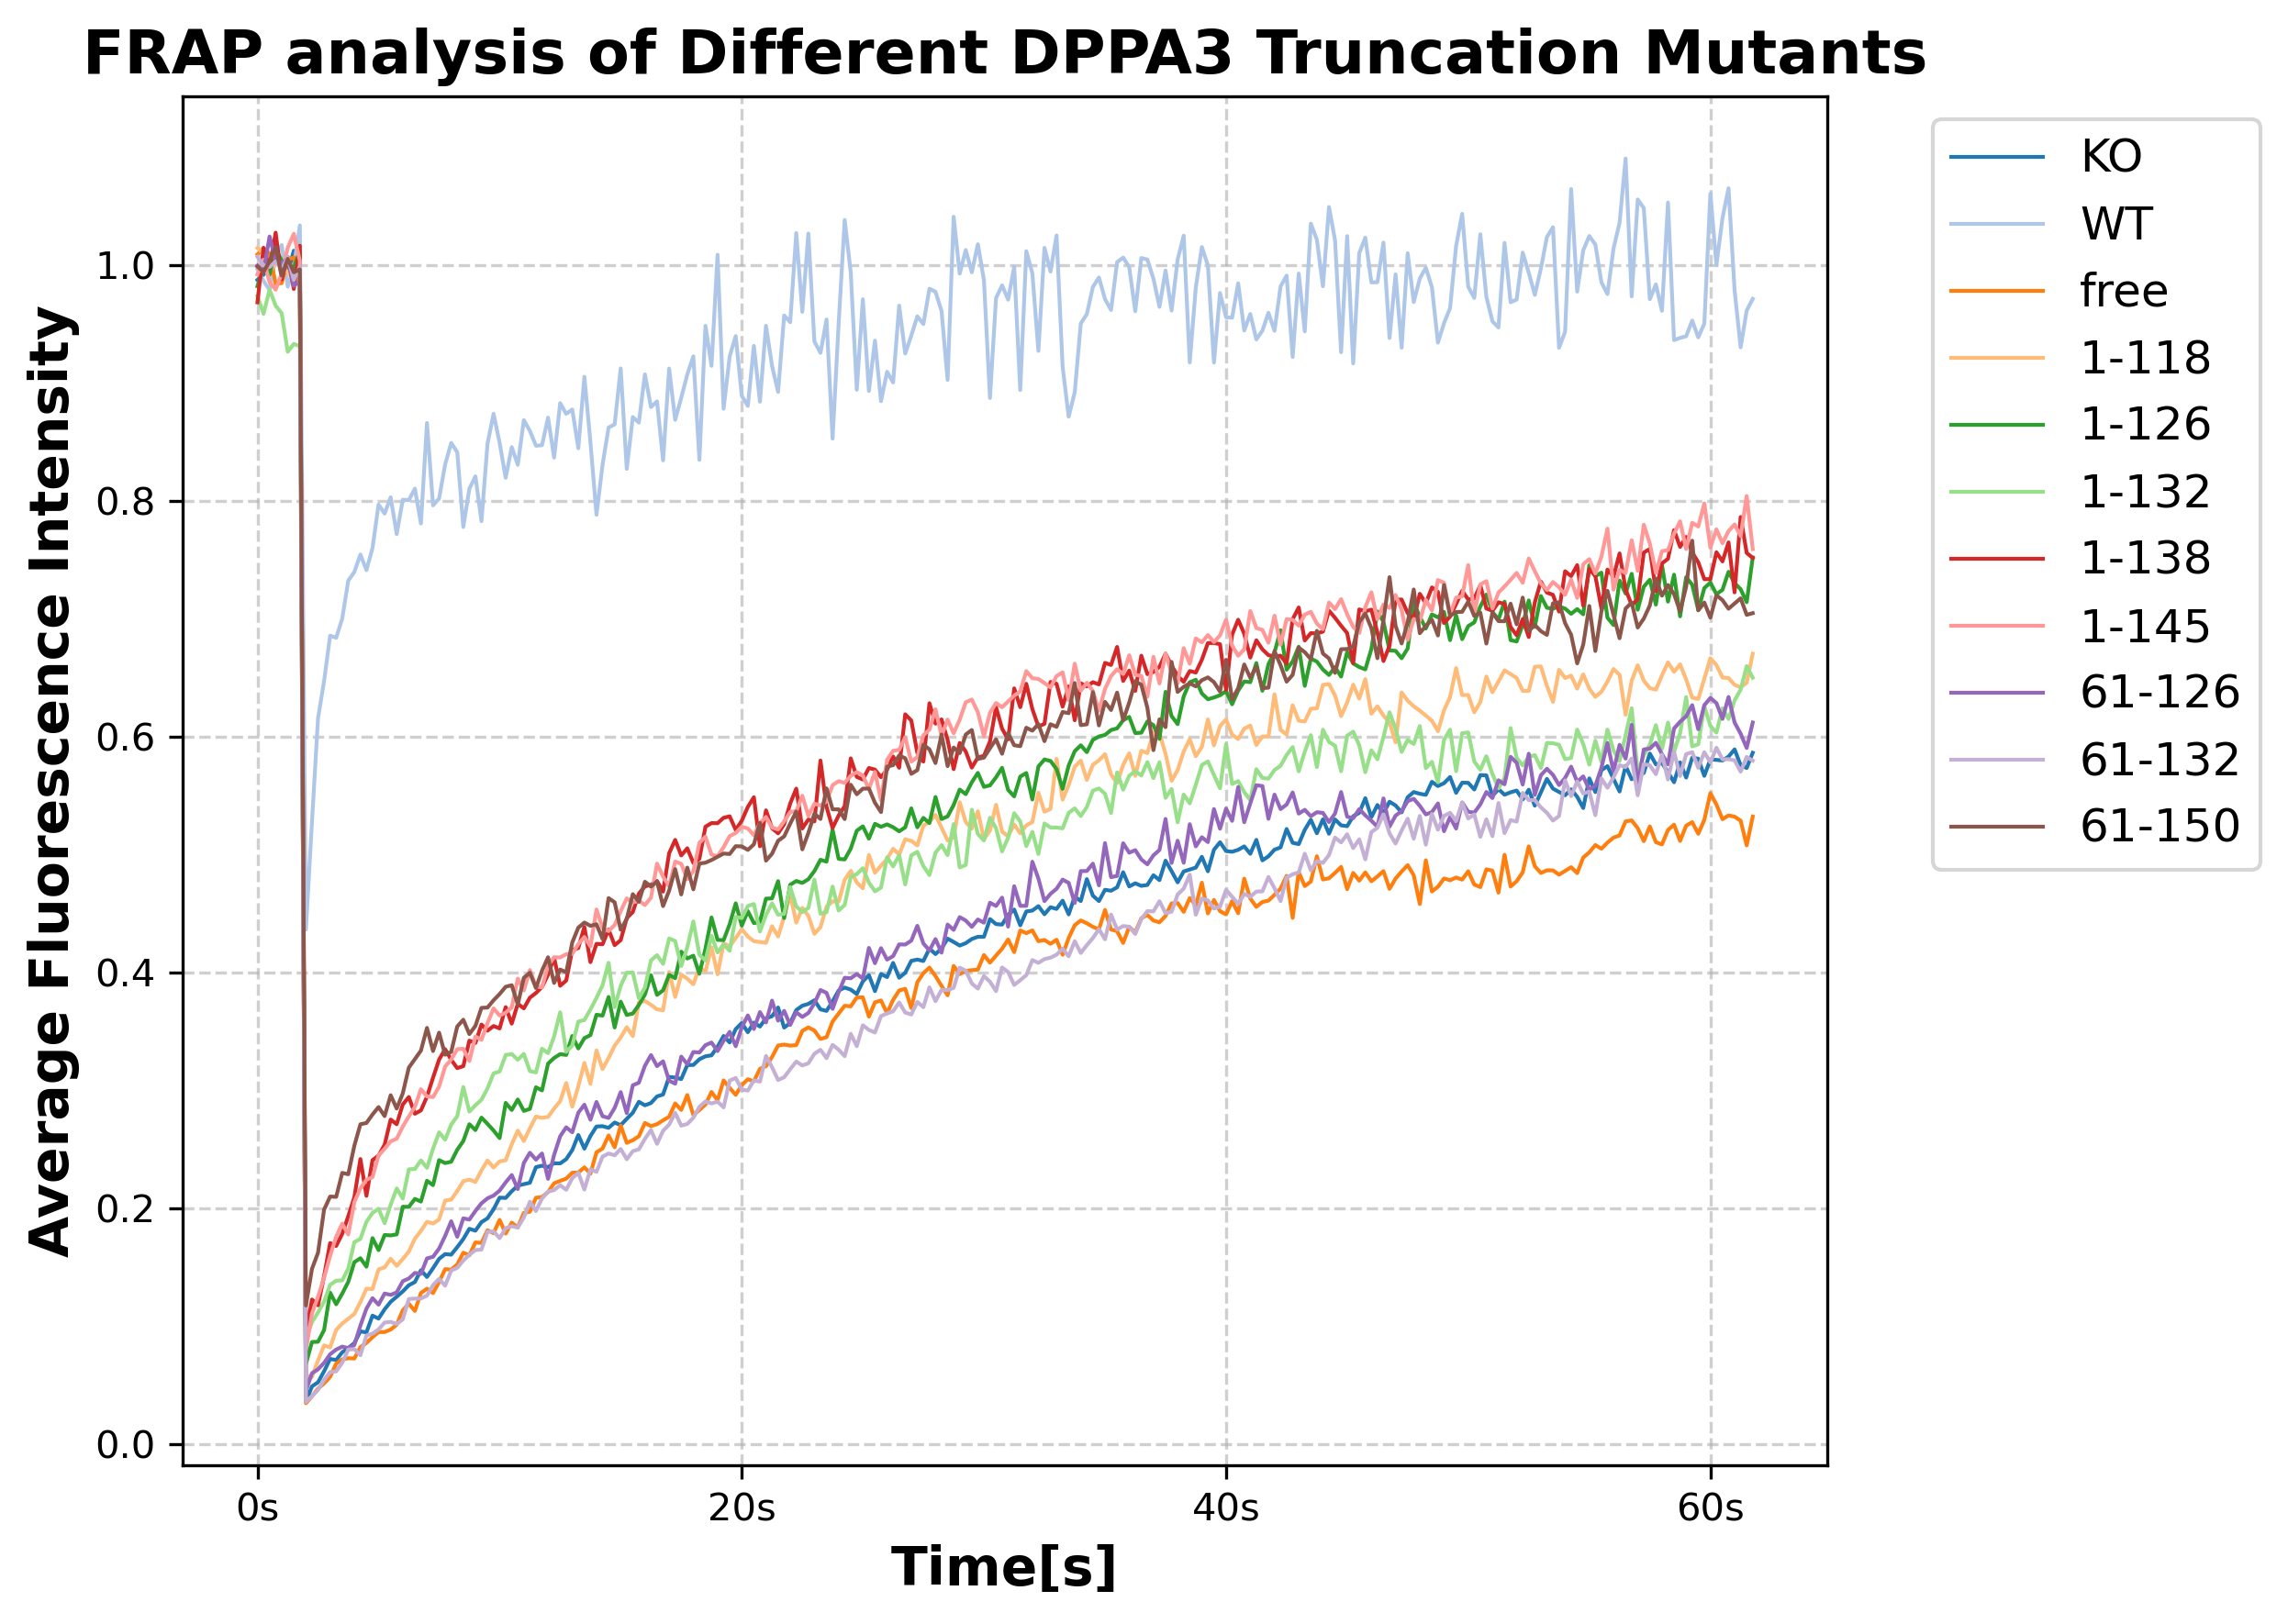

In [1]:
#Loading the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
url= 'https://docs.google.com/spreadsheets/d/1WInI7VeovJHcNxXSUJ43LhhGN1o-c-1OMmHU24payV4/export?format=csv&gid=0'
data = pd.read_csv(url)
data.head()

#Selecting specific columns
data = data[['Point', 'KO', 'WT', 'free', '1-118', '1-126', '1-132', '1-138', '1-145', '61-126', '61-132', '61-150']]
for col in data.columns:
    data[col].astype('float64')
data.head()

#Assigning  legends for axes and title
x_axis_name = 'Time[s]'
y_axis_name = 'Average Fluorescence Intensity'
plot_title = 'FRAP analysis of Different DPPA3 Truncation Mutants'

#Assigning color from color_dict
colors = plt.colormaps.get_cmap("tab20")
color_dict = {col: colors(i % 20) for i, col in enumerate(data.columns[1:])}


color_dict

plt.figure(figsize=(10, 6), dpi=300)
for column in data.columns[1:]:
    plt.plot(data['Point'], data[column], label=column, linewidth=1, color=color_dict[column])


plt.xlabel(x_axis_name, fontsize=14, fontweight='bold')
plt.ylabel(y_axis_name, fontsize=14, fontweight='bold')
plt.title(plot_title, fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1), frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)


tick_interval = 20 #(every 20 seconds)
tick_positions = range(0, 63, tick_interval) # 0-62 seconds


plt.xticks(tick_positions, [f"{t}s" for t in tick_positions], fontsize=10)
plt.style.use("seaborn-v0_8-muted")
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("plot.png", dpi=300, bbox_inches="tight")


plt.show()


Curve fitting for FRAP data to get half-time, mobile and immobile fractions

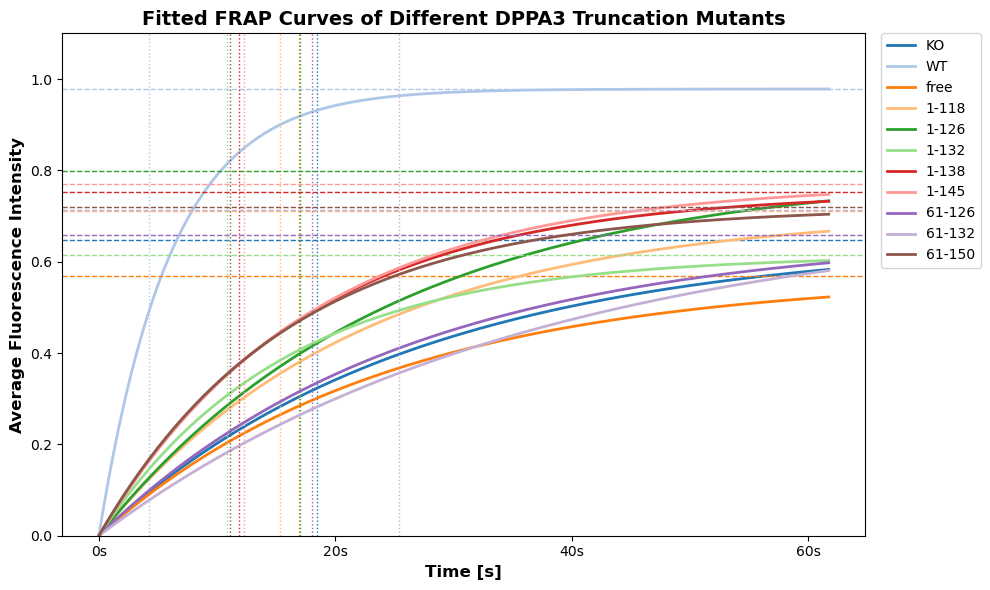


FRAP Curve Parameters:
Genotype  Half-Time (s)  Mobile Fraction (%)  Immobile Fraction (%)
      KO      18.478224            64.687957              35.312043
      WT       4.206407            97.814435               2.185565
    free      16.928853            56.808699              43.191301
   1-118      15.332350            71.036968              28.963032
   1-126      17.001885            79.766353              20.233647
   1-132      10.832001            61.434561              38.565439
   1-138      11.864023            75.267792              24.732208
   1-145      12.318461            77.119156              22.880844
  61-126      18.032126            65.903384              34.096616
  61-132      25.421221            71.304552              28.695448
  61-150      11.080325            71.904411              28.095589


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import re

# Load the data
#data = pd.read_csv('for python plots - FRAP mean + SD.csv')
url = 'https://docs.google.com/spreadsheets/d/1WInI7VeovJHcNxXSUJ43LhhGN1o-c-1OMmHU24payV4/export?format=csv&gid=1015252390'
data = pd.read_csv(url)

# Extract time points (assuming first column is time)
time_points = data.iloc[:, 0]

# Identify genotype names while keeping the correct order from the data sheet
column_names = data.columns[1:]  # Ignore the time column
genotypes = list(dict.fromkeys(re.sub(r'_(mean|SD)$', '', col, flags=re.IGNORECASE) for col in column_names))

# Define the FRAP recovery function
def frap_recovery(t, a, tau):
    return a * (1 - np.exp(-t / tau))

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 6))

# Generate distinct colors using tab20 colormap
colors = plt.colormaps.get_cmap("tab20")
color_dict = {col: colors(i % 20) for i, col in enumerate(genotypes)}

# Dictionary to store calculated parameters
results = []

# Loop through each genotype and process its data
for genotype in genotypes:
    mean_col = f"{genotype}_mean"
    std_col = f"{genotype}_SD"

    # Extract mean values
    y_mean = data[mean_col]
    
    # Filter data to start from time point 9
    fit_mask = time_points >= 9
    fit_time = time_points[fit_mask]
    fit_y_mean = y_mean[fit_mask]

    # Assign color from color_dict
    color = color_dict[genotype]

    # Perform curve fitting
    popt, _ = curve_fit(frap_recovery, fit_time, fit_y_mean, p0=[np.max(fit_y_mean), 10])
    a_fit, tau_fit = popt

    # Compute half-time (t₁/₂)
    t_half = tau_fit * np.log(2)
    
    # Compute immobile fraction
    immobile_fraction = 1 - a_fit

    # Convert fractions to percentages
    mobile_fraction_pct = a_fit * 100
    immobile_fraction_pct = immobile_fraction * 100

    # Store results in the table
    results.append([genotype, t_half, mobile_fraction_pct, immobile_fraction_pct])

    # Generate fitted curve
    y_fit = frap_recovery(time_points, *popt)

    # Plot the fitted curve without adding "Fit" to the legend
    ax.plot(time_points, y_fit, color=color, linestyle='-', linewidth=2, label=genotype)

    # Add vertical dotted line for half-time
    ax.axvline(x=t_half, color=color, linestyle='dotted', linewidth=1)

    # Add horizontal line for the asymptote (mobile fraction `a`)
    ax.axhline(y=a_fit, color=color, linestyle='dashed', linewidth=1)

# Customize the plot
ax.set_title("Fitted FRAP Curves of Different DPPA3 Truncation Mutants", fontsize=14, fontweight='bold')
ax.set_xlabel("Time [s]", fontsize=12, fontweight='bold')
ax.set_ylabel("Average Fluorescence Intensity", fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.1)  

# Set x-axis ticks every 20 seconds
x_ticks = np.arange(0, max(time_points) + 1, 20)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{int(t)}s" for t in x_ticks])

# Move legend outside the plot (right side)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.show()

# Print the table with half-time, mobile fraction, and immobile fraction in percentages
results_df = pd.DataFrame(results, columns=["Genotype", "Half-Time (s)", "Mobile Fraction (%)", "Immobile Fraction (%)"])
print("\nFRAP Curve Parameters:")
print(results_df.to_string(index=False))